In [1]:
# Setup

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Linear Regression

- Poor performance when number of features grows large (eg., 100,000)
- As long as it can fit in the memory, it handles large training sets efficiently
- Once trained, predictions are very fast: 2x the number of features OR 2x the number instances = 2x times the processing time

In [7]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [8]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance 
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [9]:
theta_best

array([[4.20216449],
       [2.84299468]])

In [11]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance 
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.20216449],
       [9.88815385]])

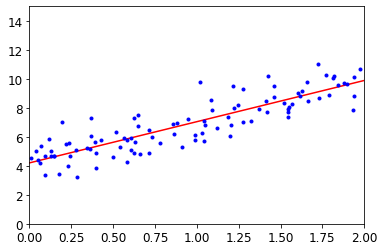

In [12]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

using sklearn LinearRegression

In [13]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.20216449]), array([[2.84299468]]))

In [14]:
lin_reg.predict(X_new)

array([[4.20216449],
       [9.88815385]])

In [15]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.20216449],
       [2.84299468]])

In [16]:
np.linalg.pinv(X_b).dot(y)

array([[4.20216449],
       [2.84299468]])

## Gradient Descent

- Tweaks parameters interatively in order to minimize a cost function
- Features should have a similar scale (using StandardScaler), or it will take a long time to converge

### Batch Gradient Descent

- Computes a partial derivative in a batch, using a learning rate multiplied by the gradient vector
- Uses the whole training set to compute the gradients at every step (very slow)

In [17]:
eta = 0.1 # learning rate 
n_iterations = 1000 
m = 100
theta = np.random.randn(2,1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y) 
    theta = theta - eta * gradients

In [18]:
theta

array([[4.20216449],
       [2.84299468]])

### Stochastic Gradient Descent

- Picks a random instance in the training set at every step and computes the gradient based only on that single instance (much faster than batch gradient descent)
- Due to random nature, it is less regular than batch gradient descent, bouncing up and down and decreasing to the minimum only on average
- It reaches to good parameter values, but usually not the optimal
- Better chance to find the global minima, when comparing to batch gradient descent, specially on irregular cost functions
- By gradually reducing the learning rate, we can make quick progress and escape the local minima at the beggining, and while the learning rate gets smaller, it helps settle at the global minimum.

In [19]:
n_epoch = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1) # random initialization

for epoch in range(n_epoch):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients =2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [20]:
theta

array([[4.19705338],
       [2.85473474]])

using sklearn SGDRegressor

In [21]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [23]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21530045]), array([2.8626819]))

### Mini-batch Gradient Descent

- Instead of computing the gradients based on the full training set (as in Batch GD) or based on just one instance (as in Stochastic GD), Mini-batch GD computes the gradients on small random sets of instances called mini-batches
- Can get a performance boost from hardware optimization
- Less erratic than Stochastic GD and usualy deliver better minimum values, but it might get stuck on local minima.

## Polynomial Regression

Let's try to use a linear model to fit nonlinear data!

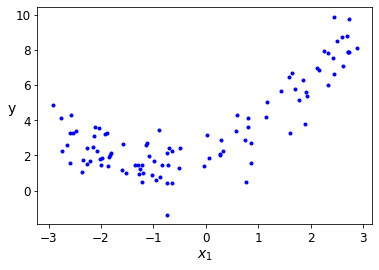

In [51]:
#  generate some nonlinear data, based on a simple quadratic equation

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
plt.xlabel("$x_1$")
plt.ylabel("y", rotation = 0)
plt.plot(X, y, "b.")

We can't fit a straight line here...<br>
Let's use PolynomialFeatures class to transform our training data, adding the square of each feature in the training set as a new feature

In [52]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-1.59859583])

In [53]:
X_poly[0]

array([-1.59859583,  2.55550864])

X_poly now has the original feature (1.79193468) and the squared (3.21102991)<br>
Now, we can fit a LinearRegression model

In [54]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.98098018]), array([[0.99317906, 0.53494309]]))

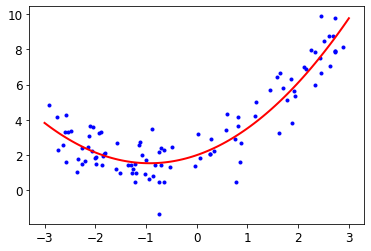

In [55]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth = 2, label = "Predictions")

### Learning Curves

How to know if we are overfitting or underfitting? Check the learning curve:

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2) train_errors, val_errors = [], []
for m in range(1, len(X_train)):
            model.fit(X_train[:m], y_train[:m])
            y_train_predict = model.predict(X_train[:m])
            y_val_predict = model.predict(X_val)
            train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
            val_errors.append(mean_squared_error(y_val, y_val_predict))
        plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
        plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")